## 训

In [1]:
import sys
sys.path.append("..")
from utils.models import *
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import os
import subprocess
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.optim import AdamW
import torch
print(torch.__version__)


model_dir = "../resources/open_models/FinBert"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
bert_backbone = AutoModel.from_pretrained(model_dir)
model = BaseModel.use_subclass("bert_classifier")(bert_backbone,2,device_map="cuda:1")

/mnt/disk2/xinghua.jia/.miniforge3/envs/finbot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1+cu124


In [2]:
class CLSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        初始化数据集
        Args:
            texts (list): 包含文本的列表
            labels (list): 文本对应的标签列表
            tokenizer (PreTrainedTokenizer): 分词器实例
            max_length (int): 文本最大长度，超过此长度将会截断
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """
        获取数据样本，并将文本转为 BERT 可用的输入格式
        Args:
            idx (int): 索引值
        Returns:
            dict: 包含 `input_ids`, `attention_mask`, `labels` 的字典
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # 对文本进行编码
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # 获取编码结果并移除不必要的维度
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

df = pd.read_json("../resources/data/Dataset-of-financial-news-sentiment-classification.jsonl", lines=True)
train_df = df.query("split == 'train'")
train_ds = CLSDataset(
    tokenizer = tokenizer,
    texts = train_df['text'].to_list(),
    labels = train_df['label'].to_list(),
    max_length = 512,
)

train_size = int(0.7 * len(train_ds))  # 70% 的训练数据
val_size = len(train_ds) - train_size   # 剩余的 30% 作为验证数据
train_subset, val_subset = random_split(train_ds, [train_size, val_size]) 



In [3]:
batch_size = 128  # 设置批量大小
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
optimizer = AdamW(model.classifier.parameters(), lr=2e-5)  # 只更新分类头的参数
criterion = nn.CrossEntropyLoss()
num_epochs = 50

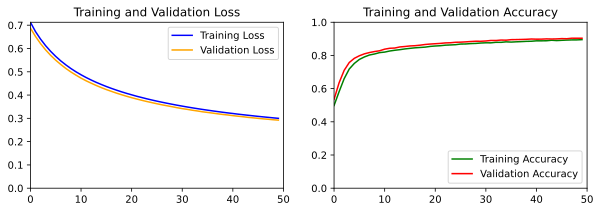

Epoch [50/50], Average Training Loss: 0.3000, Training Accuracy: 0.8953, Average Validation Loss: 0.2923, Validation Accuracy: 0.9037


In [4]:
## 开启训练
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(dpi=500)  # 设置图形的 DPI (每英寸点数)

# 训练和评估模型
train_losses = []  # 用于存储每个 epoch 的训练平均 loss
val_losses = []    # 用于存储每个 epoch 的验证平均 loss
train_accuracies = []  # 用于存储每个 epoch 的训练精确度
val_accuracies = []    # 用于存储每个 epoch 的验证精确度

# plt.ion()  # 开启交互模式

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = model.train(train_dl, criterion, optimizer)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    avg_val_loss, val_accuracy = model.eval(val_dl, criterion)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
    fig.subplots_adjust(hspace=0.3)  # 调整子图间隔
    # 更新损失图
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='orange')
    ax1.set_xlim(0, epoch + 1)  # 动态调整 x 轴
    ax1.set_ylim(0, max(max(train_losses), max(val_losses, default=0), 1e-10))  # 动态调整 y 轴
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation Loss')

    # 更新准确度图
    ax2.plot(train_accuracies, label='Training Accuracy', color='green')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_xlim(0, epoch + 1)  # 动态调整 x 轴
    ax2.set_ylim(0, 1)  # 精确度范围在 [0, 1]
    ax2.legend(loc='lower right')
    ax2.set_title('Training and Validation Accuracy')
    
    plt.pause(1e-9)  # 暂停以更新图形

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Average Training Loss: {avg_train_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, "
          f"Average Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")
    

In [ ]:
import json
import os
save_dir = '../resources/ckpts/finbert'
model.save(save_dir)
# 保存训练指标
metrics = dict(
    base='finbert',
    epochs=list(range(1, num_epochs + 1)),
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies
)

metrics_json_path = os.path.join(save_dir, 'training_metrics.json')
with open(metrics_json_path, 'w') as json_file:
    json.dump(metrics, json_file, ensure_ascii=True)
print(f"Training metrics saved to {metrics_json_path}")

## 推

In [ ]:
## 推理
import sys
sys.path.append("..")
from utils.models import *
from transformers import AutoTokenizer, AutoModel

model_dir = "../resources/open_models/FinBert"
bert_backbone = AutoModel.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = BaseModel.use_subclass("bert_classifier")(bert_backbone,2)

ckpt_dir = '../resources/ckpts/finbert'
model.load(ckpt_dir)


In [ ]:
model

In [ ]:
seqs = ["盛运环保2月13日晚间发布公告称，截至目前，共有37.48亿元到期债务未清偿。", "真好啊"]
input_tokens = tokenizer(seqs, return_tensors="pt", padding=True, truncation=True, max_length=512)
model.pred(input_tokens)